### iris를 이용한 붓꽃 예측
+ 붓꽃의 품종은 범주형이므로, 분석방법은 분류분석 이용

In [1]:
import pandas as pd
import seaborn as sns

In [2]:
# FutureWarning, UserWarning 감추기
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
# 소수점 자리 지정 (float을 출력할 때 소수점 둘째자리까지 출력하겠다 라는 옵션을 걸었음)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [11]:
iris = spark.read.csv('data/iris.csv',header=True, inferSchema=True)
iris2 = iris.toPandas()

In [12]:
iris2.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.10,3.50,1.40,0.20,setosa
1,4.90,3.00,1.40,0.20,setosa
2,4.70,3.20,1.30,0.20,setosa
3,4.60,3.10,1.50,0.20,setosa
4,5.00,3.60,1.40,0.20,setosa


#### Species 분포 확인

<Axes: xlabel='species', ylabel='count'>

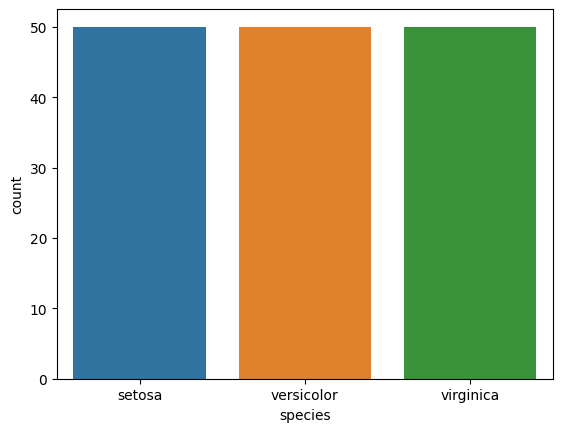

In [13]:
sns.countplot(x='species', data=iris2)
# 딱 좋은 데이터는 이렇게 종속변수의 수가 같아야함
# 일정하지 않으면 일정하게 조절을 해야함

### 독립변수 vs 종속변수
+ 독립변수(특성, fetaure) : 분석가, 연구가가 의도적으로 변화시키는 변수 (입력)
+ 종속변수(레이블, label) : 분석가, 연구자가 독립변수들의 변화에 따라 어떻게 변하는지 알고 싶어하는 변수 (결과)

### 데이터 전처리
+ 인코딩 : 독립변수의 값이 문자형인 경우 숫자형으로 바꿔주는 작업
+ 레이블인코딩 : 머신러닝시 로지스틱 회귀 분석시 사용
+ 원핫인코딩 : 머신러닝시 데이터의 종류가 이미지인 경우 사용

In [8]:
from pyspark.ml.feature import StringIndexer, VectorAssembler

In [15]:
# 레이블 인코딩 : 문자값을 0,1,2,... 순으로 변환
# StringIndexer(대상컬럼, 결과컬럼).fit(객체명)
st_idx = StringIndexer(inputCol='species', outputCol='st_idx').fit(iris)
st_idx

StringIndexerModel: uid=StringIndexer_243a7e819dd4, handleInvalid=error

In [17]:
# 레이블인코딩 기준(st_idx)을 이용해서 species 컬럼의 값을 숫자로 변환
iris = st_idx.transform(iris)

In [18]:
# 변환 결과 확인
iris.select('species', 'st_idx').show(5)

+-------+------+
|species|st_idx|
+-------+------+
| setosa|   0.0|
| setosa|   0.0|
| setosa|   0.0|
| setosa|   0.0|
| setosa|   0.0|
+-------+------+
only showing top 5 rows



#### 분석을 위해 데이터 재구성
* feature : sepal_length, sepal_width, petal_length, petal_width
* label : species

In [19]:
iris.show(5)
# 따로 있는 컬럼들을 하나로 합쳐야지 작동이 됨 (vectorAssembler 형태로.. 1차원 배열)

+------------+-----------+------------+-----------+-------+------+
|sepal_length|sepal_width|petal_length|petal_width|species|st_idx|
+------------+-----------+------------+-----------+-------+------+
|         5.1|        3.5|         1.4|        0.2| setosa|   0.0|
|         4.9|        3.0|         1.4|        0.2| setosa|   0.0|
|         4.7|        3.2|         1.3|        0.2| setosa|   0.0|
|         4.6|        3.1|         1.5|        0.2| setosa|   0.0|
|         5.0|        3.6|         1.4|        0.2| setosa|   0.0|
+------------+-----------+------------+-----------+-------+------+
only showing top 5 rows



In [20]:
# 분석을 위해 feature와 label 지정
# vectorAssembler(피처대상컬럼, 재조합컬럼명)
vdf = VectorAssembler(
    inputCols=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
    outputCol='features')
# 합쳤을 때 나오는 이름은 features

In [21]:
iris = vdf.transform(iris)

In [22]:
iris.show(5)

+------------+-----------+------------+-----------+-------+------+-----------------+
|sepal_length|sepal_width|petal_length|petal_width|species|st_idx|         features|
+------------+-----------+------------+-----------+-------+------+-----------------+
|         5.1|        3.5|         1.4|        0.2| setosa|   0.0|[5.1,3.5,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2| setosa|   0.0|[4.9,3.0,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2| setosa|   0.0|[4.7,3.2,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2| setosa|   0.0|[4.6,3.1,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2| setosa|   0.0|[5.0,3.6,1.4,0.2]|
+------------+-----------+------------+-----------+-------+------+-----------------+
only showing top 5 rows



In [23]:
# st_idx 컬럼을 label로 변경
iris = iris.withColumnRenamed('st_idx', 'label')
iris.columns
# label로 이름 바뀐 거 확인 가능

['sepal_length',
 'sepal_width',
 'petal_length',
 'petal_width',
 'species',
 'label',
 'features']

In [25]:
# 분석을 위해 features, label만 따로 뽑아 새로운 데이터프레임으로 생성
model_df = iris.select('features', 'label')
model_df.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,3.5,1.4,0.2]|  0.0|
|[4.9,3.0,1.4,0.2]|  0.0|
|[4.7,3.2,1.3,0.2]|  0.0|
|[4.6,3.1,1.5,0.2]|  0.0|
|[5.0,3.6,1.4,0.2]|  0.0|
+-----------------+-----+
only showing top 5 rows



### 분석 시작

In [32]:
# 기존 데이터를 0.75:0.25 비율의 훈련/시험 데이터로 분할함
# randomSplit(훈련데이터비율, 시험데이터비율, 시드값) : 난수
train, test = model_df.randomSplit([0.75, 0.25], 2309071800)
# 아까 sepices 값이 50이었는데 그걸 0.75대 0.25 비율로 나눔
# train은 연습문제, test는 모의고사
# 시드값을 설정해두면 모든 사람들이 같은 값이 나옴
# 난수 = 시드값, 즉, 난수를 설정해두면 윗말대로 같은 값이 나옴

In [33]:
train.select().count(), test.select().count(), 

(110, 40)

In [34]:
# 모델 훈련
from pyspark.ml.classification import LogisticRegression

In [35]:
lg = LogisticRegression().fit(train)
lg.summary.accuracy

1.0

In [36]:
# 모델 예측
pred = lg.evaluate(test)
pred.accuracy

0.95

In [39]:
# 모델 예측 결과 확인
pred = lg.transform(test)
pred.select('probability', 'prediction').show(5, truncate=False)
# truncate=False : 짤려서 나오는 거 F 처리. 즉, 길게 다 나옴

+--------------------------------------------------+----------+
|probability                                       |prediction|
+--------------------------------------------------+----------+
|[1.0,7.911424017277428E-58,0.0]                   |0.0       |
|[1.0,5.8644051503218724E-74,0.0]                  |0.0       |
|[1.0,1.1386231833477334E-54,0.0]                  |0.0       |
|[1.0,1.2104465825625694E-50,0.0]                  |0.0       |
|[3.845324092297634E-47,1.0,4.281616538766771E-129]|1.0       |
+--------------------------------------------------+----------+
only showing top 5 rows

